# QML Hackathon 



In [27]:
% matplotlib inline

import matplotlib.pyplot as plt

import os

import pandas as pd
import numpy as np
import seaborn as sns

In [28]:
test = pd.read_csv('./data/test.csv')
test_id = test.id

train = pd.read_csv('./data/train.csv')

In [29]:
# get coordinate information

ga_cols = []
al_cols = []
o_cols = []
in_cols = []

import warnings
warnings.filterwarnings("ignore")

for i in range(6):
    ga_cols.append("Ga_"+str(i))

for i in range(6):
    al_cols.append("Al_"+str(i))

for i in range(6):
    o_cols.append("O_"+str(i))

for i in range(6):
    in_cols.append("In_"+str(i))



ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=np.float),x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=np.float))
    return pos_data, np.array(lat_data)



for i in train.id.values:
    fn = "./data/train/{}/geometry.xyz".format(i)
    train_xyz, train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    for li in train_xyz:
        try:
            if li[1] == "Ga":
                ga_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "Al":
                al_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "In":
                in_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "O":
                o_list.append(li[0])
        except:
            pass
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    
ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

train = pd.merge(train,ga_df,on = ["id"],how = "left")
train = pd.merge(train,al_df,on = ["id"],how = "left")
train = pd.merge(train,o_df,on = ["id"],how = "left")
train = pd.merge(train,in_df,on = ["id"],how = "left")

ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

for i in test.id.values:
    fn = "./data/test/{}/geometry.xyz".format(i)
    test_xyz, test_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    for li in test_xyz:
        try:
            if li[1] == "Ga":
                ga_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "Al":
                al_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "In":
                in_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "O":
                o_list.append(li[0])
        except:
            pass
    
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    

ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

test = pd.merge(test,ga_df,on = ["id"],how = "left")
test = pd.merge(test,al_df,on = ["id"],how = "left")
test = pd.merge(test,o_df,on = ["id"],how = "left")
test = pd.merge(test,in_df,on = ["id"],how = "left")

In [30]:
train.rename(columns={
    'spacegroup' : 'sg',
    'number_of_total_atoms' : 'Natoms',
    'percent_atom_al' : 'x_Al',
    'percent_atom_ga' : 'x_Ga',
    'percent_atom_in' : 'x_In',
    'lattice_vector_1_ang' : 'a',
    'lattice_vector_2_ang' : 'b',
    'lattice_vector_3_ang' : 'c',
    'lattice_angle_alpha_degree' : 'alpha',
    'lattice_angle_beta_degree' : 'beta',
    'lattice_angle_gamma_degree' : 'gamma',
    'formation_energy_ev_natom' : 'E',
    'bandgap_energy_ev' : 'Eg'}, inplace=True)

test.rename(columns={
    'spacegroup' : 'sg',
    'number_of_total_atoms' : 'Natoms',
    'percent_atom_al' : 'x_Al',
    'percent_atom_ga' : 'x_Ga',
    'percent_atom_in' : 'x_In',
    'lattice_vector_1_ang' : 'a',
    'lattice_vector_2_ang' : 'b',
    'lattice_vector_3_ang' : 'c',
    'lattice_angle_alpha_degree' : 'alpha',
    'lattice_angle_beta_degree' : 'beta',
    'lattice_angle_gamma_degree' : 'gamma',
}, inplace=True)


target = [
    'E',
    'Eg']

all_data = pd.concat((train, test))

In [38]:
def get_prop_list(path_to_element_data):
    """
    Args:
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        list of elemental properties (str) which have corresponding .csv files
    """
    return [f[:-4] for f in os.listdir(path_to_element_data)]

# folder which contains element data
path_to_element_data = './data/elemental-properties/'
# get list of properties which have data files
properties = get_prop_list(path_to_element_data)
print(sorted(properties))

['EA', 'HOMO', 'IP', 'LUMO', 'electronegativity', 'mass', 'rd_max', 'rp_max', 'rs_max']


In [39]:
def get_prop(prop, path_to_element_data):
    """
    Args:
        prop (str) - name of elemental property
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        dictionary of {element (str) : property value (float)}
    """
    fin = os.path.join(path_to_element_data, prop+'.csv')
    with open(fin) as f:
        all_els = {line.split(',')[0] : float(line.split(',')[1][:-1]) for line in f}
        my_els = ['Al', 'Ga', 'In']
        return {el : all_els[el] for el in all_els if el in my_els}

# make nested dictionary which maps {property (str) : {element (str) : property value (float)}}
prop_dict = {prop : get_prop(prop, path_to_element_data) for prop in properties}
print('The mass of aluminum is %.2f amu' % prop_dict['mass']['Al'])

The mass of aluminum is 26.98 amu


In [33]:
# average each property using the composition

def avg_prop(x_Al, x_Ga, x_In, prop):
    """
    Args:
        x_Al (float or DataFrame series) - concentration of Al
        x_Ga (float or DataFrame series) - concentration of Ga
        x_In (float or DataFrame series) - concentration of In
        prop (str) - name of elemental property
    Returns:
        average property for the compound (float or DataFrame series), 
        weighted by the elemental concentrations
    """
    els = ['Al', 'Ga', 'In']
    concentration_dict = dict(zip(els, [x_Al, x_Ga, x_In]))
    return np.sum(prop_dict[prop][el] * concentration_dict[el] for el in els)

# add averaged properties to DataFrame
for prop in properties:
    all_data['_'.join(['avg', prop])] = avg_prop(all_data['x_Al'], 
                                                 all_data['x_Ga'],
                                                 all_data['x_In'],
                                                 prop)

In [40]:
# calculate the volume of the structure

def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    all_data['_'.join([lang, 'r'])] = np.pi * all_data[lang] / 180
    
# compute the cell volumes 
all_data['vol'] = get_vol(all_data['a'], all_data['b'], all_data['c'],
                          all_data['alpha_r'], all_data['beta_r'], all_data['gamma_r'])

# calculate the atomic density
all_data['atomic_density'] = all_data['Natoms'] / all_data['vol']  

In [41]:
all_data.head()

,Al_0,Al_1,Al_2,Al_3,Al_4,Al_5,E,Eg,Ga_0,Ga_1,...,avg_rd_max_avg,avg_EA_avg,avg_HOMO_avg,avg_mass_avg,vol_avg,alpha_r,beta_r,gamma_r,vol,atomic_density
0,0,0,0,0,0,0,0.0680,3.4387,0,0,...,2.468218,-0.236388,-2.735388,67.681214,NaN,1.570842,1.570836,1.570826,781.052081,0.102426
1,0,0,0,0,0,0,0.2490,2.9210,0,0,...,2.479713,-0.225318,-2.732593,65.267041,NaN,1.571121,1.570761,2.094439,782.500110,0.102236
2,0,0,0,0,0,0,0.1821,2.7438,0,0,...,2.503845,-0.228757,-2.731655,64.134103,NaN,1.587705,1.590393,0.532648,391.227531,0.102242
3,0,0,0,0,0,0,0.2172,3.3492,0,0,...,2.522219,-0.221849,-2.729169,61.865465,NaN,1.570601,1.571004,2.094425,293.377334,0.102257
4,0,0,0,0,0,0,0.0505,1.3793,0,0,...,2.479713,-0.225318,-2.732593,65.267041,NaN,1.570727,1.570807,2.094208,944.713843,0.084682


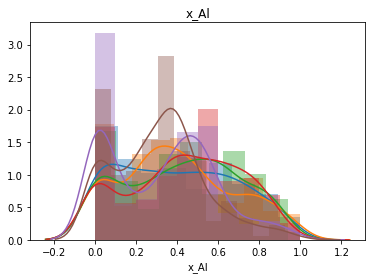

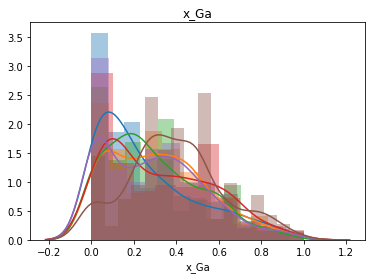

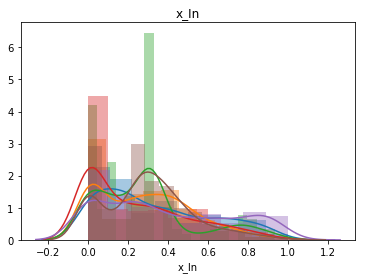

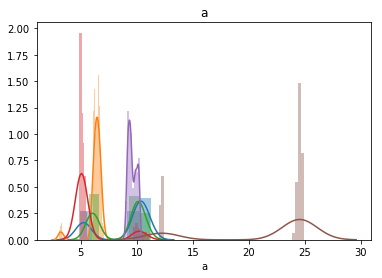

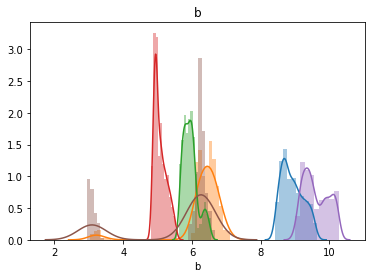

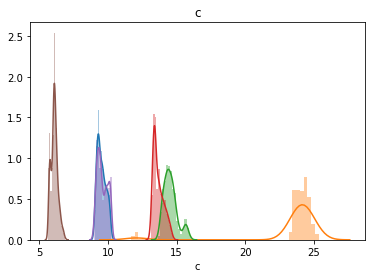

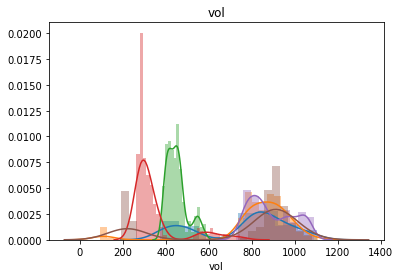

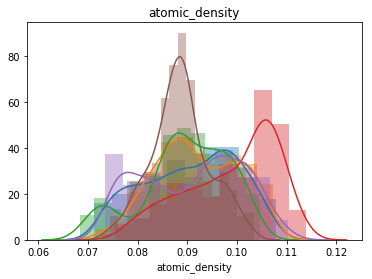

In [42]:
for col in ['x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'vol', 'atomic_density']:
    for x in all_data.sg.unique():
        sns.distplot(all_data[all_data['sg'] == x][col])
    plt.title(col)
    plt.show()

In [43]:
# make new features using averages of the following columns by sg group
avg_cols = ['x_Al','x_Ga','x_In','a','b','c','avg_rs_max','avg_electronegativity',
            'avg_rp_max','avg_LUMO','avg_IP','avg_rd_max','avg_EA','avg_HOMO',
            'avg_mass','vol','atomic_density']


for col in avg_cols:
    new_col = col + "_avg"
    all_data[new_col] = np.nan
    for group in all_data['sg'].unique():
        all_data.loc[(all_data['sg'] == group), new_col] = all_data[(all_data['sg'] == group)][col].mean()

print('Number of Null Values: {}'.format(pd.isnull(all_data[avg_cols]).sum().sum()))

Number of Null Values: 0


In [44]:
# Handle the values with categorical variables using one hot encoding
# This will create a much more sparse set of variables

all_data[['sg', 'Natoms']] = all_data[['sg', 'Natoms']].astype(str)
all_data = pd.get_dummies(all_data)

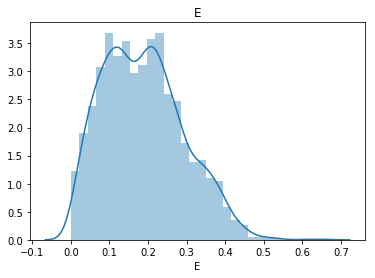

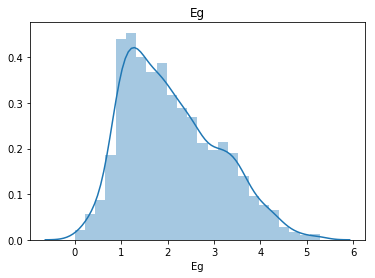

In [45]:
#  both of the target variables are skewed a bit

for col in ['E', 'Eg']:
    sns.distplot((train[col]))
    plt.title(col)
    plt.show()

In [48]:
all_data.columns

Index([u'E', u'Eg', u'a', u'alpha', u'b', u'beta', u'c', u'gamma', u'id',
       u'x_Al', u'x_Ga', u'x_In', u'avg_rs_max', u'avg_electronegativity',
       u'avg_rp_max', u'avg_LUMO', u'avg_IP', u'avg_rd_max', u'avg_EA',
       u'avg_HOMO', u'avg_mass', u'x_Al_avg', u'x_Ga_avg', u'x_In_avg',
       u'a_avg', u'b_avg', u'c_avg', u'avg_rs_max_avg',
       u'avg_electronegativity_avg', u'avg_rp_max_avg', u'avg_LUMO_avg',
       u'avg_IP_avg', u'avg_rd_max_avg', u'avg_EA_avg', u'avg_HOMO_avg',
       u'avg_mass_avg', u'vol_avg', u'alpha_r', u'beta_r', u'gamma_r', u'vol',
       u'atomic_density', u'atomic_density_avg', u'Al_0_0', u'Al_1_0',
       u'Al_2_0', u'Al_3_0', u'Al_4_0', u'Al_5_0', u'Ga_0_0', u'Ga_1_0',
       u'Ga_2_0', u'Ga_3_0', u'Ga_4_0', u'Ga_5_0', u'In_0_0', u'In_1_0',
       u'In_2_0', u'In_3_0', u'In_4_0', u'In_5_0', u'Natoms_10.0',
       u'Natoms_20.0', u'Natoms_30.0', u'Natoms_40.0', u'Natoms_60.0',
       u'Natoms_80.0', u'O_0_0', u'O_1_0', u'O_2_0', u'O_3_0', u'O_4_0'

In [70]:
all_data.to_csv('all_data.csv')
all_data.columns

Index([u'E', u'Eg', u'a', u'alpha', u'b', u'beta', u'c', u'gamma', u'id',
       u'x_Al', u'x_Ga', u'x_In', u'avg_rs_max', u'avg_electronegativity',
       u'avg_rp_max', u'avg_LUMO', u'avg_IP', u'avg_rd_max', u'avg_EA',
       u'avg_HOMO', u'avg_mass', u'x_Al_avg', u'x_Ga_avg', u'x_In_avg',
       u'a_avg', u'b_avg', u'c_avg', u'avg_rs_max_avg',
       u'avg_electronegativity_avg', u'avg_rp_max_avg', u'avg_LUMO_avg',
       u'avg_IP_avg', u'avg_rd_max_avg', u'avg_EA_avg', u'avg_HOMO_avg',
       u'avg_mass_avg', u'vol_avg', u'alpha_r', u'beta_r', u'gamma_r', u'vol',
       u'atomic_density', u'atomic_density_avg', u'Al_0_0', u'Al_1_0',
       u'Al_2_0', u'Al_3_0', u'Al_4_0', u'Al_5_0', u'Ga_0_0', u'Ga_1_0',
       u'Ga_2_0', u'Ga_3_0', u'Ga_4_0', u'Ga_5_0', u'In_0_0', u'In_1_0',
       u'In_2_0', u'In_3_0', u'In_4_0', u'In_5_0', u'Natoms_10.0',
       u'Natoms_20.0', u'Natoms_30.0', u'Natoms_40.0', u'Natoms_60.0',
       u'Natoms_80.0', u'O_0_0', u'O_1_0', u'O_2_0', u'O_3_0', u'O_4_0'

## Load data

In [71]:
new_all_data = pd.read_csv('all_data.csv')
new_all_data.columns

Index([u'Unnamed: 0', u'E', u'Eg', u'a', u'alpha', u'b', u'beta', u'c',
       u'gamma', u'id', u'x_Al', u'x_Ga', u'x_In', u'avg_rs_max',
       u'avg_electronegativity', u'avg_rp_max', u'avg_LUMO', u'avg_IP',
       u'avg_rd_max', u'avg_EA', u'avg_HOMO', u'avg_mass', u'x_Al_avg',
       u'x_Ga_avg', u'x_In_avg', u'a_avg', u'b_avg', u'c_avg',
       u'avg_rs_max_avg', u'avg_electronegativity_avg', u'avg_rp_max_avg',
       u'avg_LUMO_avg', u'avg_IP_avg', u'avg_rd_max_avg', u'avg_EA_avg',
       u'avg_HOMO_avg', u'avg_mass_avg', u'vol_avg', u'alpha_r', u'beta_r',
       u'gamma_r', u'vol', u'atomic_density', u'atomic_density_avg', u'Al_0_0',
       u'Al_1_0', u'Al_2_0', u'Al_3_0', u'Al_4_0', u'Al_5_0', u'Ga_0_0',
       u'Ga_1_0', u'Ga_2_0', u'Ga_3_0', u'Ga_4_0', u'Ga_5_0', u'In_0_0',
       u'In_1_0', u'In_2_0', u'In_3_0', u'In_4_0', u'In_5_0', u'Natoms_10.0',
       u'Natoms_20.0', u'Natoms_30.0', u'Natoms_40.0', u'Natoms_60.0',
       u'Natoms_80.0', u'O_0_0', u'O_1_0', u'O_2_0', u'O

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# features to use
features = ['x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta',
            'gamma', 'vol', 'atomic_density', 'x_Al_avg','x_Ga_avg', 'x_In_avg', 'a_avg',
            'b_avg', 'c_avg', 'vol_avg', 'atomic_density_avg', 'pca_abc', 'pca_AlGaInDensity',
            'O_0_0','O_1_0', 'O_2_0', 'O_3_0', 'O_4_0', 'O_5_0', 'Al_0_0', 'Al_1_0', 'Al_2_0', 'Al_3_0', 'Al_4_0', 'Al_5_0', 'Ga_0_0',
            'Ga_1_0', 'Ga_2_0', 'Ga_3_0', 'Ga_4_0', 'Ga_5_0', 'In_0_0', 'In_1_0',
            'In_2_0', 'In_3_0', 'In_4_0', 'In_5_0',]

# two different vectors for pca
vector1 = all_data[['a', 'b', 'c']].values
vector2 = all_data[['x_Al', 'x_Ga', 'x_In', 'atomic_density_avg']].values

# use pca to add new features
pca = PCA()
pca.fit(vector1)
all_data['pca_abc'] = pca.transform(vector1)[:,0]

pca = PCA()
pca.fit(vector2)
all_data['pca_AlGaInDensity'] = pca.transform(vector2)[:,0]

# scaling the data. Linear models tend to like more normally distributed
# I tried training on non-scaled, with slightly worse results
scale = StandardScaler()
scaled = scale.fit(all_data[features]).transform(all_data[features])

X_scale = scaled[:train.shape[0]]
X_scaled_test = scaled[train.shape[0]:]

X_tr = all_data[:train.shape[0]][features].values
X_te = all_data[train.shape[0]:][features].values

y1 = np.log1p(train['E'])
y2 = np.log1p(train['Eg'])

y12 = np.column_stack((y1, y2))

X_tr.shape, y1.shape, y2.shape, y12.shape, X_scaled_test.shape



((2400, 45), (2400,), (2400,), (2400, 2), (600, 45))

## Preformance Metric

In [51]:
# performance matric
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    
#     h, y = np.expm1(h), np.expm1(y)
    
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

## Gradient Boosting

In [54]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

In [55]:
# run different model for different Target Variables

grad_1 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=7,
                n_estimators=1120,
                max_features=7,
                min_samples_leaf=43,
                min_samples_split=14,
                min_weight_fraction_leaf=0.01556)

grad_2 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=6,
                n_estimators=3275,
                max_features=2,
                min_samples_leaf=2,
                min_samples_split=2,
                min_weight_fraction_leaf=0.08012)

def assess_grad(X, y_list, model_list):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = model_list[idx]
            model.fit(X_train, y_train)
            h =  model.predict(X_test)
            e = rmsle(np.expm1(h), np.expm1(y_test))
            print(e)
            out.append(e)
        final.append(np.array(out).mean())
                      
    return(np.array(final).mean(), np.array(final).std())

In [56]:
model = assess_grad(X_tr, [y1, y2], [grad_1, grad_2])
print("Model RMSLE: {}, std: {}".format(model[0], model[1]))

0.03178055447913692
0.03258705099311187
0.03044170604201252
0.03575894444316086
0.03128782476145822
0.030706748269280052
0.03219995325364419
0.03365027372148944
0.03804225798772755
0.02949260901146122
0.08881088782485726
0.08785369168154712
0.10219906480717202
0.08342088694783478
0.10763651456281154
0.08336803289208099
0.09271406432184885
0.08828853744055663
0.08936209506821383
0.08736857679891202
Model RMSLE: 0.0618485137654, std: 0.0292537214692
